# Качество воздуха в ближайшем городе

- [**Дашборд «Индекс качества воздуха»**](https://lookerstudio.google.com/reporting/e1123b91-adca-4516-914b-1b13d36093a6)

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Качество-воздуха-в-ближайшем-городе" data-toc-modified-id="Качество-воздуха-в-ближайшем-городе-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Качество воздуха в ближайшем городе</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li></ul></li><li><span><a href="#Подключение-к-AirVisual-API" data-toc-modified-id="Подключение-к-AirVisual-API-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подключение к AirVisual API</a></span></li><li><span><a href="#Подключение-к-Google-Sheets-API" data-toc-modified-id="Подключение-к-Google-Sheets-API-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подключение к Google Sheets API</a></span></li><li><span><a href="#Дашборд" data-toc-modified-id="Дашборд-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Дашборд</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

Ход проекта
- Подключение к API [AQAir](https://www.iqair.com/ru/world-air-quality).
- Получение текущего индекса качества воздуха (AQI) и погоды в ближайшем городе, используя геолокацию IP-адреса.
- Вывод данных в датафрейм.
- Подключение к Google Sheets API.
- Обновление данных в Google Sheets.
- Вывод полученной информации на дашборд в Looker Studio с подключением к Google Sheets.

## Импорт библиотек

In [1]:
import requests
import pandas as pd
import pprint as pp
import gspread
from google.oauth2 import service_account

from datetime import datetime

# Подключение к AirVisual API

[Ссылка на документацию AirVisual API](https://api-docs.iqair.com/?version=latest#5bc93d6b-d563-43dc-adb9-c266b2e96d4a)

Сохраним ссылку и ключ API в переменных `url` и `key` соответственно.

In [2]:
# http://api.airvisual.com/v2/city?city=Los Angeles&state=California&country=USA&key={{YOUR_API_KEY}}

url = 'http://api.airvisual.com/v2/city'
key = 'YOUR_API_KEY'

Напишем запрос на получение списка доступных стран.

In [3]:
r = requests.get('http://api.airvisual.com/v2/countries?key={{YOUR_API_KEY}}')

print(r)

<Response [200]>


Вывод результата запроса.

In [4]:
r.json()

{'status': 'success',
 'data': [{'country': 'Afghanistan'},
  {'country': 'Albania'},
  {'country': 'Algeria'},
  {'country': 'Andorra'},
  {'country': 'Angola'},
  {'country': 'Anguilla'},
  {'country': 'Argentina'},
  {'country': 'Armenia'},
  {'country': 'Australia'},
  {'country': 'Austria'},
  {'country': 'Azerbaijan'},
  {'country': 'Bahamas'},
  {'country': 'Bahrain'},
  {'country': 'Bangladesh'},
  {'country': 'Barbados'},
  {'country': 'Belgium'},
  {'country': 'Belize'},
  {'country': 'Bermuda'},
  {'country': 'Bolivia'},
  {'country': 'Bosnia Herzegovina'},
  {'country': 'Brazil'},
  {'country': 'Bulgaria'},
  {'country': 'Burkina Faso'},
  {'country': 'Burundi'},
  {'country': 'Cambodia'},
  {'country': 'Cameroon'},
  {'country': 'Canada'},
  {'country': 'Cape Verde'},
  {'country': 'Cayman Islands'},
  {'country': 'Central African Republic'},
  {'country': 'Chad'},
  {'country': 'Chile'},
  {'country': 'China'},
  {'country': 'Colombia'},
  {'country': 'Costa Rica'},
  {'c

Россия есть в списке доступных стран.

Напишем запрос на получение списка доступных регионов России.

In [5]:
r = requests.get('http://api.airvisual.com/v2/states?country=Russia&key={{YOUR_API_KEY}}')

print(r)
# pp.pprint(r.json())

<Response [200]>


Вывод результата запроса.

In [6]:
r.json()

{'status': 'success',
 'data': [{'state': 'Adygeya'},
  {'state': 'Altai'},
  {'state': 'Altai Krai'},
  {'state': 'Amur'},
  {'state': 'Arkhangelskaya'},
  {'state': 'Astrakhan'},
  {'state': 'Bashkortostan'},
  {'state': 'Belgorod'},
  {'state': 'Brjansk'},
  {'state': 'Chechnya'},
  {'state': 'Chelyabinsk'},
  {'state': 'Chukotka'},
  {'state': 'Chuvashia'},
  {'state': 'Dagestan'},
  {'state': 'Ingushetiya'},
  {'state': 'Irkutsk'},
  {'state': 'Ivanovo'},
  {'state': 'Jaroslavl'},
  {'state': 'Kabardino-Balkariya'},
  {'state': 'Kaliningrad'},
  {'state': 'Kalmykiya'},
  {'state': 'Kaluga'},
  {'state': 'Kamtsjatka'},
  {'state': 'Karachayevo-Cherkesiya'},
  {'state': 'Karelia'},
  {'state': 'Kemerovo'},
  {'state': 'Khabarovsk'},
  {'state': 'Khakasiya'},
  {'state': 'Khanty-Mansia'},
  {'state': 'Kirov'},
  {'state': 'Komi'},
  {'state': 'Kostroma'},
  {'state': 'Krasnodarskiy'},
  {'state': 'Krasnoyarsk Krai'},
  {'state': 'Kurgan'},
  {'state': 'Kursk'},
  {'state': "Leningrad

Получили названия регионов. Для некоторых регионов нет названия региона, а есть название города.

Напишем запрос на получение данных по Москве с помощью параметров.

In [7]:
payload = {'city': 'Moscow', 'state': 'Moscow', 'country': 'Russia', 'key': key}
r = requests.get(url, params = payload)

print(r)

<Response [200]>


Вывод результата запроса.

In [8]:
r.json()

{'status': 'success',
 'data': {'city': 'Moscow',
  'state': 'Moscow',
  'country': 'Russia',
  'location': {'type': 'Point', 'coordinates': [37.61556, 55.75222]},
  'current': {'pollution': {'ts': '2024-04-24T09:00:00.000Z',
    'aqius': 21,
    'mainus': 'p2',
    'aqicn': 7,
    'maincn': 'p2'},
   'weather': {'ts': '2024-04-24T08:00:00.000Z',
    'tp': 9,
    'pr': 1022,
    'hu': 41,
    'ws': 1.59,
    'wd': 231,
    'ic': '04d'}}}}

Получили данные по качеству воздуха, погоде, координатах Москвы.

Напишем запрос на получение данных по ближайшему городу, используя геолокацию IP-адреса.

In [9]:
r = requests.get('http://api.airvisual.com/v2/nearest_city?key={{YOUR_API_KEY}}')

print(r) 

<Response [200]>


Вывод результата запроса несколькими способами (для удобства).

In [10]:
r.json()

{'status': 'success',
 'data': {'city': 'Nizhniy Novgorod',
  'state': 'Nizjnij Novgorod',
  'country': 'Russia',
  'location': {'type': 'Point', 'coordinates': [44.00205, 56.32867]},
  'current': {'pollution': {'ts': '2024-04-24T06:00:00.000Z',
    'aqius': 19,
    'mainus': 'p2',
    'aqicn': 7,
    'maincn': 'p2'},
   'weather': {'ts': '2024-04-24T08:00:00.000Z',
    'tp': 12,
    'pr': 1020,
    'hu': 44,
    'ws': 6,
    'wd': 250,
    'ic': '01d'}}}}

In [11]:
pp.pprint(r.json())   

{'data': {'city': 'Nizhniy Novgorod',
          'country': 'Russia',
          'current': {'pollution': {'aqicn': 7,
                                    'aqius': 19,
                                    'maincn': 'p2',
                                    'mainus': 'p2',
                                    'ts': '2024-04-24T06:00:00.000Z'},
                      'weather': {'hu': 44,
                                  'ic': '01d',
                                  'pr': 1020,
                                  'tp': 12,
                                  'ts': '2024-04-24T08:00:00.000Z',
                                  'wd': 250,
                                  'ws': 6}},
          'location': {'coordinates': [44.00205, 56.32867], 'type': 'Point'},
          'state': 'Nizjnij Novgorod'},
 'status': 'success'}


In [12]:
print(' Ближайший город', r.json()['data']['city'])

 Ближайший город Nizhniy Novgorod


In [13]:
print('Текущий AQI в ближайшем городе', r.json()['data']['current']['pollution']['aqius'])

Текущий AQI в ближайшем городе 19


Сбросим ограничения на количество символов в записи.

In [14]:
pd.set_option('display.max_colwidth', None)

Выведем результат запроса в датафрейм.

In [15]:
df = pd.read_json(r.text)
df

,status,data
city,success,Nizhniy Novgorod
country,success,Russia
current,success,"{'pollution': {'ts': '2024-04-24T06:00:00.000Z', 'aqius': 19, 'mainus': 'p2', 'aqicn': 7, 'maincn': 'p2'}, 'weather': {'ts': '2024-04-24T08:00:00.000Z', 'tp': 12, 'pr': 1020, 'hu': 44, 'ws': 6, 'wd': 250, 'ic': '01d'}}"
location,success,"{'type': 'Point', 'coordinates': [44.00205, 56.32867]}"
state,success,Nizjnij Novgorod


Распарсим данные по качеству воздуха, приведем данные в столбце `ts` к нужному формату `дата и время` и запишем полученные данные в датафрейм.

In [16]:
summary = pd.json_normalize(r.json()["data"]["current"]["pollution"], meta="ts").assign(
    ts=lambda x: pd.to_datetime(x.ts, format="%Y-%m-%dT%H:%M:%S.%fZ")
)

summary

,ts,aqius,mainus,aqicn,maincn
0,2024-04-24 06:00:00,19,p2,7,p2


[Справка из документации](https://api-docs.iqair.com/?version=latest#5bc93d6b-d563-43dc-adb9-c266b2e96d4a)
  - Станции по всему миру имеют циклы обновления, которые отличаются друг от друга.
  - Данные со станций обновляются только один раз в час.
  - API возвращает вычисленный AQI для каждого загрязнителя и для станции (основного загрязнителя).
  - API возвращает 2 типа AQI: AQI в США (EPA) и AQI в Китае.
  - Информация о станциях может периодически обновляться. Например, могут корректироваться их GPS-координаты или изменяться названия. 
  - Если станция не выдает значения загрязнения, это означает, что данные не были опубликованы за данный конкретный час.
  - Загрязняющие вещества не всегда имеют одинаковые единицы измерения концентрации. Иногда CO указывается в мкг/м3, а иногда в промилле. Однако значения PM2,5 и PM10 всегда указываются в мкг/м3.

Распарсим данные по погоде, приведем данные в столбце `ts` к нужному формату `дата и время` и запишем полученные данные в датафрейм.

In [17]:
weather = pd.json_normalize(r.json()['data']['current']['weather'], meta = 'ts').assign(
    ts = lambda x: pd.to_datetime(x.ts, format = '%Y-%m-%dT%H:%M:%S.%fZ')
)

weather

,ts,tp,pr,hu,ws,wd,ic
0,2024-04-24 08:00:00,12,1020,44,6,250,01d


Получили текущие данные о температуре воздуха, влажности воздуха и т.д.

Распарсим данные по координатам города и запишем полученные данные в датафрейм.

In [18]:
coord = pd.json_normalize(r.json()['data']['location'])

coord

,type,coordinates
0,Point,"[44.00205, 56.32867]"


Получили координаты ближайшего города.

Сведем полученную информацию в один датафрейм.

In [19]:
summary['nearest city'] = df['data'][0]
summary['weather tp'] = weather['tp']
summary['weather pr'] = weather['pr']
summary['weather hu'] = weather['hu']
summary['weather ws'] = weather['ws']
summary['weather wd'] = weather['wd']
summary['weather ic'] = weather['ic']
summary['coordinates longitude'] = coord['coordinates'][0][0]
summary['coordinates latitude'] = coord['coordinates'][0][1]

# Преобразование даты в строку для сериализации объекта Timestamp в формат JSON для обновления данных в Google Sheets 
summary['ts'] = summary['ts'].dt.strftime('%Y-%m-%d %H:%M:%S')
# Добавление даты и времени записи данных 
summary['timestamp'] = datetime.now().strftime('%Y-%m-%d %H:%M')

summary

,ts,aqius,mainus,aqicn,maincn,nearest city,weather tp,weather pr,weather hu,weather ws,weather wd,weather ic,coordinates longitude,coordinates latitude,timestamp
0,2024-04-24 06:00:00,19,p2,7,p2,Nizhniy Novgorod,12,1020,44,6,250,01d,44.00205,56.32867,2024-04-24 12:07


Получили необходимые данные.

# Подключение к Google Sheets API

In [20]:
# Подключение к Google Sheets API
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
credentials = service_account.Credentials.from_service_account_file(
    r'C:\Users\amo\Documents\python\API key\credentials.json', scopes=scope)

gc = gspread.authorize(credentials)

# Открываем Google Sheets документ по названию
worksheet = gc.open("summary_data").sheet1

# Обновление данных в Google Sheets
worksheet.update([summary.columns.values.tolist()] + summary.values.tolist())

{'spreadsheetId': '1vwBnnewrbCQfp8m7N-3-RTBwllgi1lx0EQIQWZXZP2Y',
 'updatedRange': "'Лист1'!A1:O2",
 'updatedRows': 2,
 'updatedColumns': 15,
 'updatedCells': 30}

Данные в Google Sheets обновлены.

# Дашборд

Полученная информация выведена на дашборд [«Индекс качества воздуха»](https://lookerstudio.google.com/reporting/e1123b91-adca-4516-914b-1b13d36093a6) в Looker Studio с подключением к Google Sheets.

Создано поле, которое выводит текствоый комментарий, соответствующий [легенде индекса качества воздуха США](https://www.iqair.com/ru/world-air-quality-ranking). Цвет карточки индекса качества воздуха на дашборде меняется с помощью условного форматирования. Цветовой код:

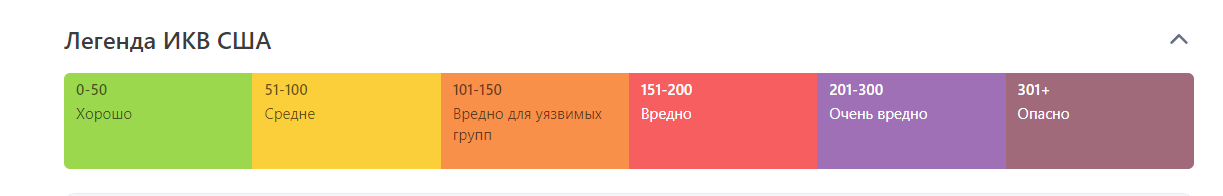

# Вывод

- Осуществлено подключение к API [AQAir](https://www.iqair.com/ru/world-air-quality).
- Получен текущий индекс качества воздуха (AQI) и погода в ближайшем городе, используя геолокацию IP-адреса.
- Данные выведены в датафрейм.
- Осуществлено подключение к Google Sheets API.
- Произведено обновление данных в Google Sheets.
- Полученная информация выведена на дашборд [«Индекс качества воздуха»](https://lookerstudio.google.com/reporting/e1123b91-adca-4516-914b-1b13d36093a6) в Looker Studio с подключением к Google Sheets.